In [7]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer


In [8]:
train_data_file = "Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


In [9]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [10]:
features = basic_transforamtion(features)

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [13]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [14]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [15]:
datasets["valid"].__getitem__(0)

(tensor([ 1.3830, -0.0121, -0.0142,  0.2311, -0.5876, -1.2248,  0.7084, -2.9106,
         -1.5882, -2.1764, -0.0873,  3.0382,  1.2874,  2.0683,  1.7239,  1.3785],
        device='cuda:1'), tensor(0., device='cuda:1'))

In [32]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=128,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [33]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[-0.3521, -0.0044, -0.0164,  ..., -0.7917, -1.1850, -1.0632],
        [ 1.5036, -0.0062, -0.0124,  ..., -0.8277, -1.2186, -0.8724],
        [-0.4998, -0.0103, -0.0094,  ..., -0.4765, -0.2310,  0.0160],
        ...,
        [ 0.2719, -0.0097, -0.0081,  ..., -0.6685, -0.2651, -0.1217],
        [ 1.6949, -0.0102, -0.0091,  ..., -0.6166, -0.3375, -0.0190],
        [-0.1744, -0.0079, -0.0109,  ..., -0.7156, -0.9665, -0.6698]],
       device='cuda:1') 128
target tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1.

In [54]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
        
            for i, batch in enumerate(dataloaders[phase]):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build the shallow model

In [55]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2)
        self.inputs = inputs
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
        x = self.output_layer(x)
        return x

In [56]:
n_hidden = {0:40,
            1:30,
           2:20,
           3:10,
           4:10}

model = NHiddenTrackingNetwork(X_train.shape[1], 5, n_hidden).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=16, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [59]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([40, 16])
input_layer.bias 	 torch.Size([40])
layers.0.weight 	 torch.Size([30, 40])
layers.0.bias 	 torch.Size([30])
layers.1.weight 	 torch.Size([20, 30])
layers.1.bias 	 torch.Size([20])
layers.2.weight 	 torch.Size([10, 20])
layers.2.bias 	 torch.Size([10])
layers.3.weight 	 torch.Size([10, 10])
layers.3.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [60]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 0.3226, train acc: 0.8671, elapsed:212.8854
valid loss: 0.3198, valid acc: 0.8686, elapsed:34.3513

Epoch 2/50
----------
train loss: 0.3202, train acc: 0.8680, elapsed:222.9755
valid loss: 0.3181, valid acc: 0.8693, elapsed:34.0804

Epoch 3/50
----------
train loss: 0.3183, train acc: 0.8689, elapsed:219.5408
valid loss: 0.3157, valid acc: 0.8705, elapsed:36.5808

Epoch 4/50
----------
train loss: 0.3164, train acc: 0.8696, elapsed:232.0067
valid loss: 0.3164, valid acc: 0.8695, elapsed:34.1846

Epoch 5/50
----------
train loss: 0.3148, train acc: 0.8702, elapsed:228.8702
valid loss: 0.3145, valid acc: 0.8698, elapsed:31.3418

Epoch 6/50
----------
train loss: 0.3132, train acc: 0.8711, elapsed:202.7730
valid loss: 0.3122, valid acc: 0.8715, elapsed:30.9179

Epoch 7/50
----------
train loss: 0.3118, train acc: 0.8717, elapsed:200.6794
train loss: 0.3106, train acc: 0.8722, elapsed:201.9680
valid loss: 0.3092, valid acc: 0.8727, elapsed:30.5297

Epoch

In [63]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=300)


Epoch 1/300
----------
train loss: 0.2951, train acc: 0.8794, elapsed:50.4663
valid loss: 0.2945, valid acc: 0.8798, elapsed:7.2260

Epoch 2/300
----------
train loss: 0.2951, train acc: 0.8793, elapsed:50.5974
valid loss: 0.2952, valid acc: 0.8792, elapsed:7.2262

Epoch 3/300
----------
train loss: 0.2950, train acc: 0.8794, elapsed:50.6817
valid loss: 0.2956, valid acc: 0.8791, elapsed:7.2594

Epoch 4/300
----------
train loss: 0.2949, train acc: 0.8795, elapsed:50.8232
valid loss: 0.2945, valid acc: 0.8797, elapsed:7.1918

Epoch 5/300
----------
train loss: 0.2947, train acc: 0.8795, elapsed:50.6589
valid loss: 0.2940, valid acc: 0.8801, elapsed:7.1963

Epoch 6/300
----------
train loss: 0.2946, train acc: 0.8796, elapsed:50.6281
valid loss: 0.2946, valid acc: 0.8795, elapsed:7.2203

Epoch 7/300
----------
train loss: 0.2945, train acc: 0.8796, elapsed:50.7032
valid loss: 0.2944, valid acc: 0.8797, elapsed:7.3254

Epoch 8/300
----------
train loss: 0.2945, train acc: 0.8796, elapse

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=300)


Epoch 1/300
----------
train loss: 0.2823, train acc: 0.8863, elapsed:50.5463
valid loss: 0.2833, valid acc: 0.8857, elapsed:7.2068

Epoch 2/300
----------
train loss: 0.2822, train acc: 0.8863, elapsed:50.5841
valid loss: 0.2837, valid acc: 0.8858, elapsed:7.2005

Epoch 3/300
----------
train loss: 0.2822, train acc: 0.8864, elapsed:50.4841
valid loss: 0.2824, valid acc: 0.8862, elapsed:7.2366

Epoch 4/300
----------
train loss: 0.2822, train acc: 0.8864, elapsed:50.5439
valid loss: 0.2826, valid acc: 0.8859, elapsed:7.2269

Epoch 5/300
----------
train loss: 0.2821, train acc: 0.8864, elapsed:50.4612
valid loss: 0.2841, valid acc: 0.8851, elapsed:7.2278

Epoch 6/300
----------
train loss: 0.2821, train acc: 0.8865, elapsed:50.5120
valid loss: 0.2823, valid acc: 0.8865, elapsed:7.2202

Epoch 7/300
----------
train loss: 0.2820, train acc: 0.8865, elapsed:50.5647
valid loss: 0.2824, valid acc: 0.8864, elapsed:7.3069

Epoch 8/300
----------
train loss: 0.2820, train acc: 0.8865, elapse

In [68]:
torch.save(model.state_dict(), "5NN.pt")

In [76]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


In [74]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to(device)
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    fpr, tpr, thresholds = roc_curve(Y, output.cpu().detach().numpy()[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



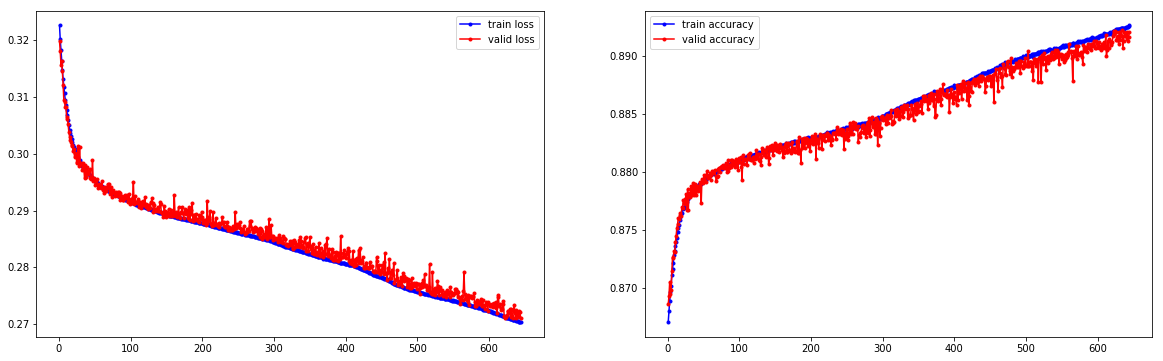

In [77]:
plot_training_classification(run_hist)

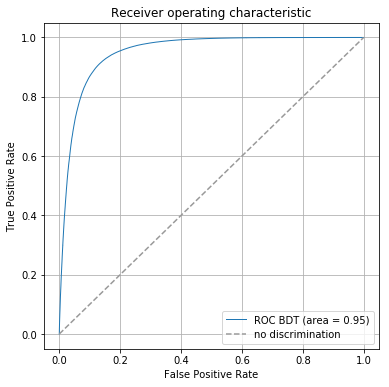

In [75]:
print_roc(model,X_valid, Y_valid )

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=300)


Epoch 1/300
----------
train loss: 0.2703, train acc: 0.8926, elapsed:51.1589
valid loss: 0.2727, valid acc: 0.8911, elapsed:7.3507

Epoch 2/300
----------
train loss: 0.2702, train acc: 0.8927, elapsed:51.1851
valid loss: 0.2716, valid acc: 0.8920, elapsed:7.3413

Epoch 3/300
----------
train loss: 0.2702, train acc: 0.8927, elapsed:51.2865
valid loss: 0.2717, valid acc: 0.8913, elapsed:7.3350

Epoch 4/300
----------
train loss: 0.2702, train acc: 0.8927, elapsed:51.1456
valid loss: 0.2710, valid acc: 0.8923, elapsed:7.3577

Epoch 5/300
----------
train loss: 0.2701, train acc: 0.8927, elapsed:51.2376
valid loss: 0.2706, valid acc: 0.8925, elapsed:7.3700

Epoch 6/300
----------
train loss: 0.2701, train acc: 0.8928, elapsed:51.1446
valid loss: 0.2731, valid acc: 0.8911, elapsed:7.3186

Epoch 7/300
----------
train loss: 0.2701, train acc: 0.8926, elapsed:51.1671
valid loss: 0.2710, valid acc: 0.8920, elapsed:7.3013

Epoch 8/300
----------
train loss: 0.2701, train acc: 0.8928, elapse

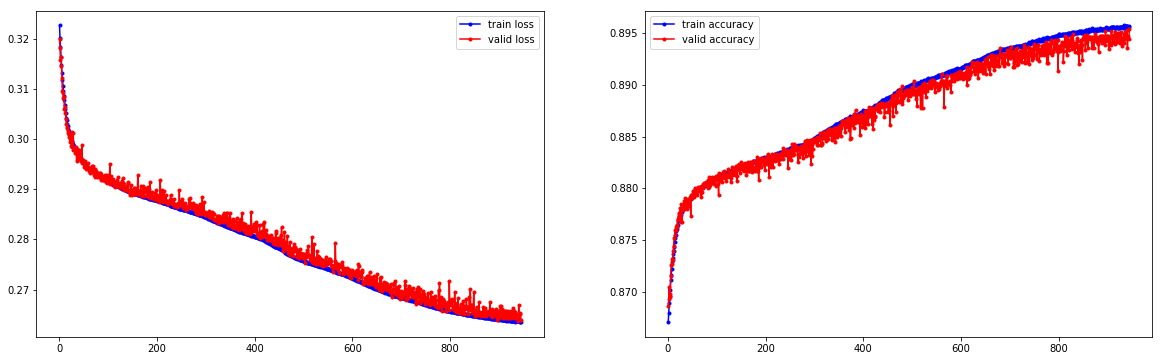

In [80]:
plot_training_classification(run_hist)

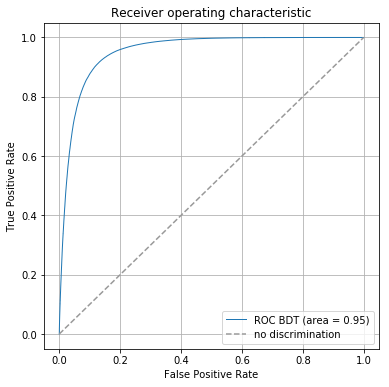

In [81]:
print_roc(model,X_valid, Y_valid )

In [83]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[ 1.4195e-01, -8.9665e-01,  3.9761e+00, -2.6983e-01, -5.6786e-01,
          1.7274e-02,  1.7037e-02, -2.6074e-03,  9.2705e-03, -1.4638e-02,
          2.2986e-02, -1.1143e-01, -2.1060e-01,  4.3165e-02,  4.0417e-02,
         -1.3879e-01],
        [ 4.4895e-02, -1.0038e+00, -1.0292e+01,  1.1108e-02,  3.4817e-01,
         -1.2236e-02, -9.8516e-05, -5.1601e-02,  7.7453e-03,  3.6539e-02,
         -1.2260e-01,  6.2039e-01,  8.4427e-02, -1.1927e-01, -1.8477e-02,
          1.2054e+00],
        [-7.3607e-03, -8.5311e+00, -7.5632e+00,  7.6472e-03,  7.9400e-04,
          4.2514e-03, -2.6915e-03,  7.6611e-03,  7.0255e-04, -7.0712e-04,
          1.6618e-01,  1.8046e-02, -5.1392e-01, -1.2711e-02,  1.0724e-01,
         -6.2271e-03],
        [-1.8445e-03, -2.1249e-01,  8.4383e-01,  4.4593e-03,  4.2347e-02,
          9.2194e-04,  4.5499e-02,  1.1263e-02, -3.9072e-02, -2.2954e-03,
          6.7247e-01,  2.6482e-01, -4.3243e-01, -9.5593e-02,  7.0448e-01

In [84]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 2872


In [86]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".5NN_2.pt")


In [97]:
learning_rate = 2*learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [98]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=100)


Epoch 1/100
----------
train loss: 0.2633, train acc: 0.8958, elapsed:57.1135
valid loss: 0.2647, valid acc: 0.8948, elapsed:8.4284

Epoch 2/100
----------
train loss: 0.2634, train acc: 0.8958, elapsed:56.4924
valid loss: 0.2647, valid acc: 0.8947, elapsed:8.3807

Epoch 3/100
----------
train loss: 0.2634, train acc: 0.8958, elapsed:56.4467
valid loss: 0.2642, valid acc: 0.8951, elapsed:8.3806

Epoch 4/100
----------
train loss: 0.2633, train acc: 0.8959, elapsed:56.4254
valid loss: 0.2648, valid acc: 0.8948, elapsed:7.8609

Epoch 5/100
----------
train loss: 0.2634, train acc: 0.8958, elapsed:52.8517
valid loss: 0.2646, valid acc: 0.8947, elapsed:8.5350

Epoch 6/100
----------
train loss: 0.2634, train acc: 0.8959, elapsed:57.1342
valid loss: 0.2650, valid acc: 0.8947, elapsed:8.1015

Epoch 7/100
----------
train loss: 0.2633, train acc: 0.8958, elapsed:57.3973
valid loss: 0.2662, valid acc: 0.8941, elapsed:8.3385

Epoch 8/100
----------
train loss: 0.2633, train acc: 0.8958, elapse